# Boosting Modeling

In [50]:
# import the package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report, make_scorer

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [51]:
# load the data
structured = pd.read_csv('data/clean_features.csv')
metadata = pd.read_csv('data/metadata.csv', index_col=0)

In [52]:
structured.head()

,PetID,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,...,10,11,12,13,14,15,16,17,18,19
0,86e1089a3,2,3,1,1,1,2,2,2,1,...,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
1,6296e909a,2,1,1,2,2,3,3,3,1,...,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
2,3422e4906,1,1,1,2,2,1,1,2,1,...,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
3,5842f1ff5,1,4,2,2,1,1,1,2,1,...,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
4,850a43f90,1,1,1,2,1,2,2,2,1,...,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [53]:
metadata.head()

,PetID,metadata_annots_score_sum,metadata_annots_score_mean,metadata_annots_score_var,metadata_color_score_sum,metadata_color_score_mean,metadata_color_score_var,metadata_color_pixelfrac_sum,metadata_color_pixelfrac_mean,metadata_color_pixelfrac_var,metadata_crop_conf_sum,metadata_crop_conf_mean,metadata_crop_conf_var,metadata_crop_importance_sum,metadata_crop_importance_mean,metadata_crop_importance_var
0,0008c5398,5.641122,0.940187,8.753511e-05,0.427536,0.071256,9.176452e-05,0.300160,0.050027,0.000036,4.8,0.8,0.0,6.0,1.0,0.0
1,000a290e4,1.884046,0.942023,5.596608e-07,0.161713,0.080857,5.431417e-07,0.114633,0.057316,0.000122,1.6,0.8,0.0,2.0,1.0,0.0
2,000fb9572,5.654862,0.942477,3.450427e-04,0.538534,0.089756,4.634404e-05,0.389065,0.064844,0.000374,4.8,0.8,0.0,6.0,1.0,0.0
3,0011d7c25,2.793139,0.931046,1.128461e-04,0.251597,0.083866,1.071002e-04,0.227523,0.075841,0.000050,2.4,0.8,0.0,3.0,1.0,0.0
4,00156db4a,4.635251,0.927050,7.186672e-04,0.418022,0.083604,3.871732e-05,0.288098,0.057620,0.000378,4.0,0.8,0.0,5.0,1.0,0.0


In [54]:
df = structured.merge(metadata, on='PetID', how='left')
df.set_index('PetID', drop=True, inplace=True)
df.head()

,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,...,metadata_color_score_var,metadata_color_pixelfrac_sum,metadata_color_pixelfrac_mean,metadata_color_pixelfrac_var,metadata_crop_conf_sum,metadata_crop_conf_mean,metadata_crop_conf_var,metadata_crop_importance_sum,metadata_crop_importance_mean,metadata_crop_importance_var
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,3,1,1,1,2,2,2,1,1,...,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN
6296e909a,2,1,1,2,2,3,3,3,1,1,...,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000
3422e4906,1,1,1,2,2,1,1,2,1,1,...,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000
5842f1ff5,1,4,2,2,1,1,1,2,1,1,...,0.000278,0.548335,0.068542,0.000571,6.4,0.8,0.0,8.00,1.000000,0.000000
850a43f90,1,1,1,2,1,2,2,2,1,1,...,0.000075,0.128066,0.042689,0.000016,2.4,0.8,0.0,2.98,0.993333,0.000133


In [ ]:
df.fillna(df.mean(), inplace=True)

In [61]:
corr_matrix = df.corr()
corr_matrix['AdoptionSpeed'].sort_values(ascending=False)

AdoptionSpeed                 1.000000
Mixed_Breed                   0.155797
Age                           0.100510
7                             0.070760
Quantity                      0.062931
                                ...   
Type                         -0.091240
FurLength                    -0.091337
metadata_annots_score_mean   -0.100917
PureBreed                    -0.101853
Other                        -0.121082
Name: AdoptionSpeed, Length: 82, dtype: float64

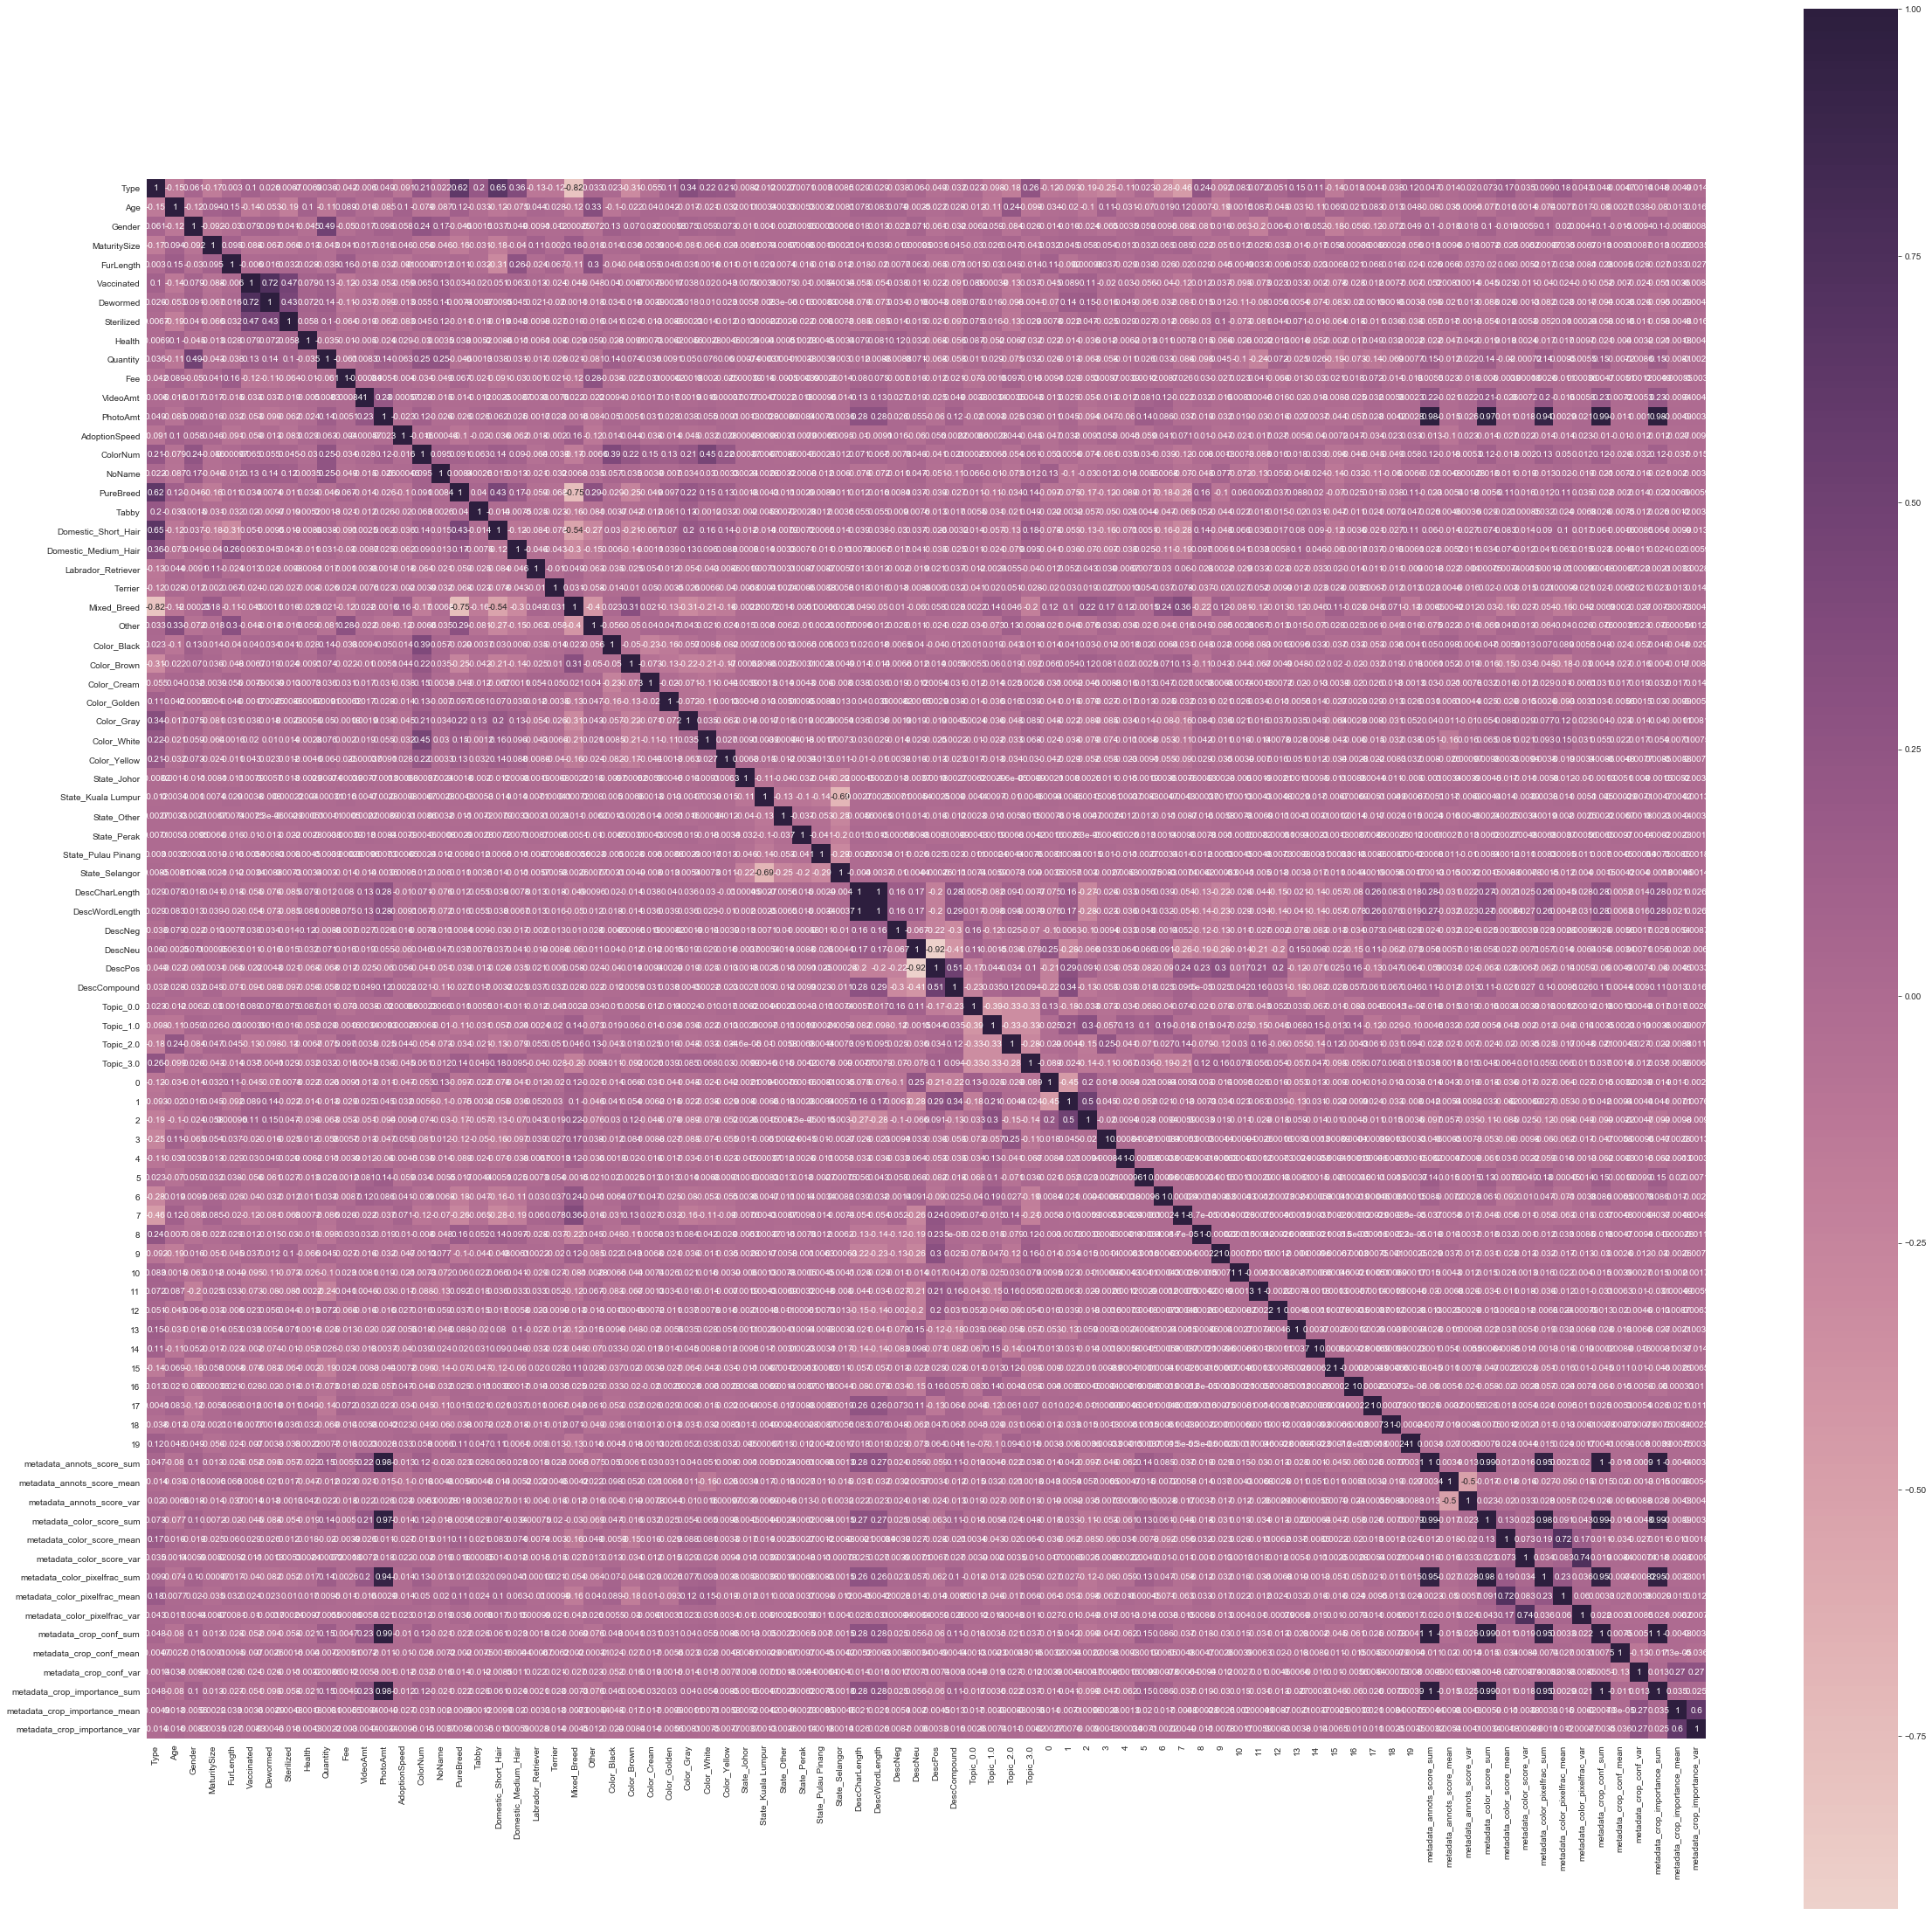

In [63]:
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, cmap=sns.cubehelix_palette(as_cmap=True), square=True, annot=True)
plt.show()

In [56]:
X = df.drop('AdoptionSpeed', axis=1)
y = df.AdoptionSpeed

In [57]:
# check missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_percentage = (df.isnull().sum()/len(df)*100).round(2)
    missing_val = pd.concat([missing, missing_percentage], axis=1)
    missing_val.columns = ['Missing Values', '% Missing']
    total_columns = df.shape[1]
    missing_columns = (df.isnull().sum()>0).sum()
    print('Out of {} columns, {} columns have missing values'.format(total_columns, missing_columns))
    return missing_val

check_missing(X)

Out of 81 columns, 0 columns have missing values


,Missing Values,% Missing
Type,0,0.0
Age,0,0.0
Gender,0,0.0
MaturitySize,0,0.0
FurLength,0,0.0
...,...,...
metadata_crop_conf_mean,0,0.0
metadata_crop_conf_var,0,0.0
metadata_crop_importance_sum,0,0.0
metadata_crop_importance_mean,0,0.0


In [58]:
y.value_counts(normalize=True)

4    0.279931
2    0.269259
3    0.217368
1    0.206096
0    0.027346
Name: AdoptionSpeed, dtype: float64

In [59]:
y_bi = label_binarize(y, classes=[0, 1, 2, 3, 4])
y_bi.shape

(14993, 5)

In [60]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

## t-SNE Visualization

In [12]:
tsne = TSNE(random_state=SEED, perplexity=40, learning_rate=50)
tsne_transformed = tsne.fit_transform(X)

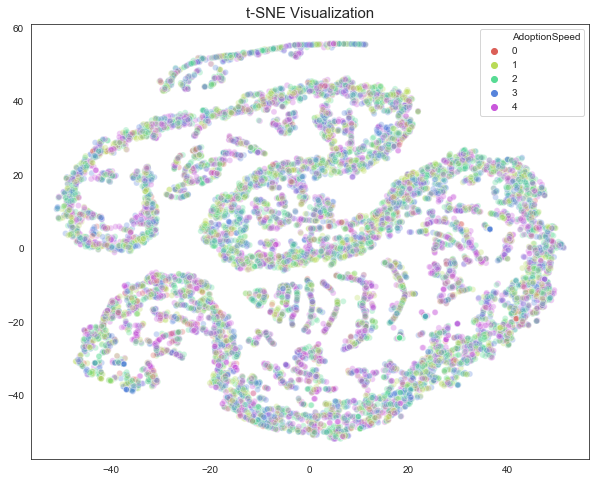

In [13]:
sns.set_style('white')
plt.figure(figsize=(10, 8))
xs = tsne_transformed[:,0]
ys = tsne_transformed[:,1]
sns.scatterplot(xs, ys, hue=y, palette=sns.color_palette('hls', 5), legend='full', alpha=0.3)
plt.title('t-SNE Visualization', fontsize=15)
plt.show()

## Modeling

In [85]:
scaler = StandardScaler()
smote = SMOTE(random_state=SEED)
lgbm = LGBMClassifier(objective='multiclass', random_state=SEED)
pipeline = Pipeline([('scaler', scaler), ('over', smote), ('classifier', lgbm)])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
f1 = make_scorer(f1_score, average='weighted')
score = cross_val_score(pipeline, X_train, y_train, scoring=f1, cv=5)

In [86]:
np.mean(score)

0.3926423277149242

In [87]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('classifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective='multiclass',
                                random_state=42, reg_alpha=0.0, reg_lambda=0.0,
                                silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [88]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))
print(cohen_kappa_score(y_test, y_pred, weights='quadratic'))
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print(classification_report(y_test, y_pred))

0.3922788343822121
0.39913304434811603
0.3876906888899377
0.39913304434811603
0.3108892008820213
0.6667459857473366
              precision    recall  f1-score   support

           0       0.38      0.07      0.12        82
           1       0.33      0.35      0.34       618
           2       0.35      0.33      0.34       807
           3       0.40      0.29      0.33       652
           4       0.47      0.62      0.54       840

    accuracy                           0.40      2999
   macro avg       0.39      0.33      0.33      2999
weighted avg       0.39      0.40      0.39      2999



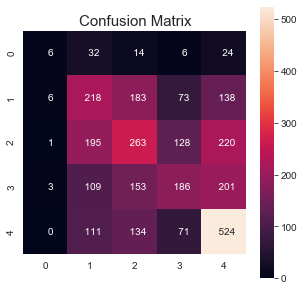

In [89]:
# visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, square=True, annot=True, fmt='5g')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

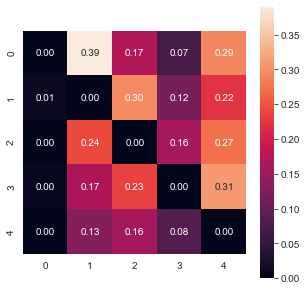

In [90]:
# normalized confusion matrix
# rows: actual classes, columns: predicted classes
row_sums = cm.sum(axis=1, keepdims=True) 
norm_conf_mx = cm / row_sums

plt.figure(figsize=(5, 5))
np.fill_diagonal(norm_conf_mx, 0) 
sns.heatmap(norm_conf_mx, square=True, annot=True, fmt='.2f') 
plt.show()

In [91]:
def feature_imp(model, X_train):
    # features and feature importances
    plt.figure(figsize = (10, 6))

    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    names = [features[i] for i in indices]

    plt.title('Feature Importance')
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), names, rotation=90)

    plt.show()

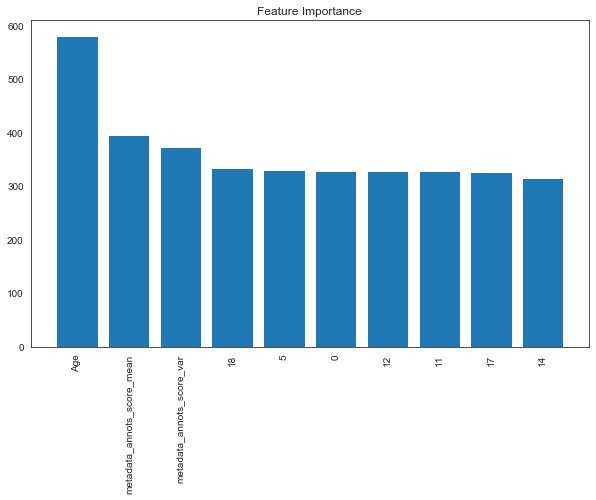

In [92]:
feature_imp(pipeline.steps[2][1], X_train)

In [35]:
def build_model(input_model, param_dist):

    # define which resampling method and which ML model to use in the pipeline
    scaler = StandardScaler()
    smote = SMOTE(random_state=SEED)
    model = input_model

    # define the pipeline, tell it to combine ADASYN with the Logistic Regression model
    pipeline = Pipeline([('Scaler', scaler), ('Oversampling', smote), ('Classifier', model)])

    # tune hyperparameter
    pipeline = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring='f1_weighted', \
                                  cv=5, n_iter=30, n_jobs=-1, random_state=SEED)

    # fit the data
    pipeline.fit(X_train, y_train)
    pipeline = pipeline.best_estimator_
    
    # track progress
    print('Done!')
    
    return pipeline

In [36]:
lgbm_param = {'Oversampling__k_neighbors': np.arange(3, 20),
              'Classifier__n_estimators': np.arange(100, 1001, 50),
              'Classifier__max_depth': np.arange(1, 10),
              'Classifier__learning_rate': np.arange(0.01, 1.7, 0.02),
              'Classifier__gamma': np.arange(0, 5.1, 0.25)
              }

cat_param = {'Oversampling__k_neighbors': np.arange(3, 20),
              'Classifier__n_estimators': np.arange(100, 1001, 50),
              'Classifier__max_depth': np.arange(1, 10),
              'Classifier__learning_rate': np.arange(0.01, 1.7, 0.02)
              }

xgb_param = {'Oversampling__k_neighbors': np.arange(3, 20),
              'Classifier__n_estimators': np.arange(100, 1001, 50),
              'Classifier__max_depth': np.arange(1, 10),
              'Classifier__learning_rate': np.arange(0.01, 1.7, 0.02),
              'Classifier__gamma': np.arange(0, 5.1, 0.25)
              }

In [38]:
lgbm = build_model(LGBMClassifier(verbose=1, random_state=SEED), lgbm_param)
cat = build_model(CatBoostClassifier(verbose=1, random_state=SEED), cat_param)
xgb = build_model(XGBClassifier(verbose=1, random_state=SEED), xgb_param)

Done!
0:	learn: 1.5983782	total: 175ms	remaining: 1m 27s
1:	learn: 1.5882654	total: 286ms	remaining: 1m 11s
2:	learn: 1.5796224	total: 397ms	remaining: 1m 5s
3:	learn: 1.5712210	total: 505ms	remaining: 1m 2s
4:	learn: 1.5641425	total: 616ms	remaining: 1m
5:	learn: 1.5560470	total: 723ms	remaining: 59.6s
6:	learn: 1.5473826	total: 832ms	remaining: 58.6s
7:	learn: 1.5400994	total: 943ms	remaining: 58s
8:	learn: 1.5332910	total: 1.05s	remaining: 57.4s
9:	learn: 1.5271159	total: 1.16s	remaining: 56.9s
10:	learn: 1.5205987	total: 1.27s	remaining: 56.4s
11:	learn: 1.5143224	total: 1.38s	remaining: 56.1s
12:	learn: 1.5086014	total: 1.49s	remaining: 55.8s
13:	learn: 1.5024115	total: 1.6s	remaining: 55.7s
14:	learn: 1.4970107	total: 1.73s	remaining: 55.9s
15:	learn: 1.4908818	total: 1.84s	remaining: 55.7s
16:	learn: 1.4854484	total: 1.96s	remaining: 55.5s
17:	learn: 1.4803966	total: 2.06s	remaining: 55.3s
18:	learn: 1.4746159	total: 2.18s	remaining: 55.2s
19:	learn: 1.4685015	total: 2.3s	remain

162:	learn: 1.1629809	total: 21.8s	remaining: 45s
163:	learn: 1.1613860	total: 21.9s	remaining: 44.9s
164:	learn: 1.1598715	total: 22s	remaining: 44.8s
165:	learn: 1.1589658	total: 22.2s	remaining: 44.6s
166:	learn: 1.1574997	total: 22.3s	remaining: 44.5s
167:	learn: 1.1561282	total: 22.5s	remaining: 44.4s
168:	learn: 1.1550379	total: 22.6s	remaining: 44.2s
169:	learn: 1.1537393	total: 22.7s	remaining: 44.1s
170:	learn: 1.1523803	total: 22.9s	remaining: 44s
171:	learn: 1.1511838	total: 23s	remaining: 43.9s
172:	learn: 1.1497483	total: 23.1s	remaining: 43.7s
173:	learn: 1.1485921	total: 23.3s	remaining: 43.6s
174:	learn: 1.1474659	total: 23.4s	remaining: 43.5s
175:	learn: 1.1461837	total: 23.5s	remaining: 43.3s
176:	learn: 1.1451647	total: 23.7s	remaining: 43.2s
177:	learn: 1.1439135	total: 23.8s	remaining: 43.1s
178:	learn: 1.1431629	total: 24s	remaining: 43s
179:	learn: 1.1420144	total: 24.1s	remaining: 42.8s
180:	learn: 1.1410919	total: 24.2s	remaining: 42.7s
181:	learn: 1.1400155	to

322:	learn: 1.0096005	total: 43.6s	remaining: 23.9s
323:	learn: 1.0086828	total: 43.7s	remaining: 23.7s
324:	learn: 1.0079994	total: 43.9s	remaining: 23.6s
325:	learn: 1.0072689	total: 44s	remaining: 23.5s
326:	learn: 1.0064228	total: 44.1s	remaining: 23.3s
327:	learn: 1.0055973	total: 44.3s	remaining: 23.2s
328:	learn: 1.0049544	total: 44.4s	remaining: 23.1s
329:	learn: 1.0043006	total: 44.6s	remaining: 23s
330:	learn: 1.0035934	total: 44.7s	remaining: 22.8s
331:	learn: 1.0027295	total: 44.9s	remaining: 22.7s
332:	learn: 1.0020813	total: 45s	remaining: 22.6s
333:	learn: 1.0012884	total: 45.1s	remaining: 22.4s
334:	learn: 1.0004244	total: 45.3s	remaining: 22.3s
335:	learn: 0.9999011	total: 45.4s	remaining: 22.2s
336:	learn: 0.9993728	total: 45.5s	remaining: 22s
337:	learn: 0.9985085	total: 45.7s	remaining: 21.9s
338:	learn: 0.9978379	total: 45.8s	remaining: 21.8s
339:	learn: 0.9969506	total: 45.9s	remaining: 21.6s
340:	learn: 0.9963476	total: 46.1s	remaining: 21.5s
341:	learn: 0.995304

482:	learn: 0.8985408	total: 1m 5s	remaining: 2.3s
483:	learn: 0.8978205	total: 1m 5s	remaining: 2.17s
484:	learn: 0.8969687	total: 1m 5s	remaining: 2.03s
485:	learn: 0.8966335	total: 1m 5s	remaining: 1.9s
486:	learn: 0.8958629	total: 1m 6s	remaining: 1.76s
487:	learn: 0.8951845	total: 1m 6s	remaining: 1.63s
488:	learn: 0.8945282	total: 1m 6s	remaining: 1.49s
489:	learn: 0.8940727	total: 1m 6s	remaining: 1.35s
490:	learn: 0.8934603	total: 1m 6s	remaining: 1.22s
491:	learn: 0.8928658	total: 1m 6s	remaining: 1.08s
492:	learn: 0.8922837	total: 1m 6s	remaining: 949ms
493:	learn: 0.8915733	total: 1m 6s	remaining: 813ms
494:	learn: 0.8910708	total: 1m 7s	remaining: 678ms
495:	learn: 0.8905112	total: 1m 7s	remaining: 542ms
496:	learn: 0.8900091	total: 1m 7s	remaining: 407ms
497:	learn: 0.8892810	total: 1m 7s	remaining: 271ms
498:	learn: 0.8886165	total: 1m 7s	remaining: 136ms
499:	learn: 0.8880992	total: 1m 7s	remaining: 0us
Done!
Done!


In [39]:
def score(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    cv_f1 = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', verbose=True, n_jobs=-1))
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_ck = cohen_kappa_score(y_test, y_test_pred, weights='quadratic')
    test_rocauc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    train_scores.append(train_f1)
    cv_scores.append(cv_f1)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)
    test_cks.append(test_ck)
    test_rocaucs.append(test_rocauc)

In [47]:
train_scores = []
cv_scores = []
test_precisions = []
test_recalls = []
test_f1s = []
test_cks = []
test_rocaucs = []

score(lgbm)
score(cat)
score(xgb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.9min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.7min remaining: 34.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.7min finished


In [48]:
# take a look at the scores and go back to tune the hyperparameters if see any indication of overfitting or underfitting
classifiers = ['LightGBM', 'CatBoost', 'XGBoost']
result = pd.DataFrame({'Train F1': train_scores, 'CV F1': cv_scores, 'Test Precision': test_precisions, 'Test Recall': test_recalls, \
                       'Test F1': test_f1s, 'Test Cohen Kappa': test_cks, 'Test ROCAUC': test_rocaucs}, index = classifiers)
result.sort_values(by='Test F1', ascending = False)

,Train F1,CV F1,Test Precision,Test Recall,Test F1,Test Cohen Kappa,Test ROCAUC
LightGBM,1.000000,0.401415,0.396877,0.401801,0.394281,0.301546,0.668152
XGBoost,0.783844,0.397002,0.394571,0.400800,0.390486,0.322632,0.664205
CatBoost,0.700951,0.398130,0.394477,0.400133,0.386721,0.332645,0.669540


<Figure size 432x288 with 0 Axes>

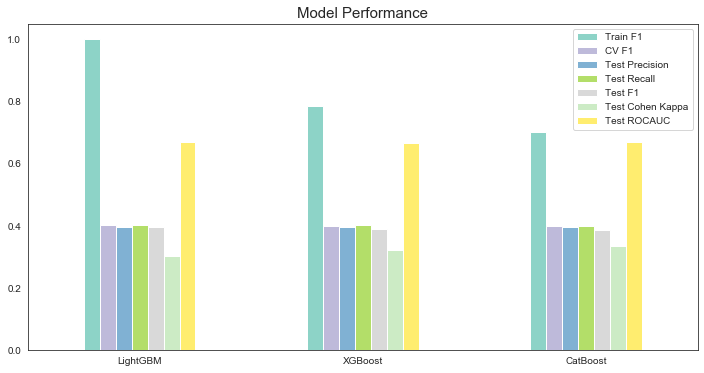

In [49]:
# visualize the metrics
tuned_score = result.sort_values(by = 'Test F1', ascending = False)

fig = plt.figure()

tuned_score.plot.bar(rot=0, colormap = 'Set3', figsize=(12,6))
plt.title('Model Performance', fontsize = 15)

plt.show()